In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heartpy as hp

In [2]:
#TIMING

base_path = '/Users/laura/Documents/RICHEMONT/250319/Clement/Polar ECG/19-03-2025, 1051 AM-'


for i in range(1, 9):
    file_path = f'{base_path}{i}.csv'
    df = pd.read_csv(file_path)
    

    timestamp = df.iloc[0, 0]
    
    try:
        real_time = pd.to_datetime(timestamp, unit='ns')
    except:

        real_time = pd.to_datetime(timestamp)
    
    print(f'Archivo {i}: start = {real_time}')


Archivo 1: start = 2025-03-19 09:51:46.854203852
Archivo 2: start = 2025-03-19 10:51:46.714478903
Archivo 3: start = 2025-03-19 11:51:46.339577163
Archivo 4: start = 2025-03-19 12:51:49.750024843
Archivo 5: start = 2025-03-19 13:51:49.967729023
Archivo 6: start = 2025-03-19 14:51:49.964289577
Archivo 7: start = 2025-03-19 15:51:50.219096249
Archivo 8: start = 2025-03-19 16:51:50.403040121


In [3]:

base_path = '/Users/laura/Documents/RICHEMONT/250319/Clement/Polar ECG/19-03-2025, 1051 AM-'

dfs = []
for i in range(1, 9):
    file_path = f'{base_path}{i}.csv'
    df = pd.read_csv(file_path)
    
    timestamp = df.iloc[0, 0]
    df['real_time'] = pd.to_datetime(df.iloc[:, 0], unit='ns') 
    
    dfs.append(df)



In [4]:
#boutiques
polar = pd.concat(dfs).reset_index(drop=True)


boutique_intervals = {
    'Boutique_1': ('2025-03-19 11:29:00', '2025-03-19 12:03:00'),
    'Boutique_2': ('2025-03-19 12:03:00', '2025-03-19 12:45:00'),
    'Boutique_3': ('2025-03-19 12:45:00', '2025-03-19 13:14:00'),
}

for name, (start_str, end_str) in boutique_intervals.items():
    boutique_intervals[name] = (pd.to_datetime(start_str), pd.to_datetime(end_str))


boutique_dfs = {}
for name, (start_time, end_time) in boutique_intervals.items():
    mask = (polar['real_time'] >= start_time) & (polar['real_time'] < end_time)
    boutique_dfs[name] = polar.loc[mask].reset_index(drop=True)

df_boutique1 = boutique_dfs['Boutique_1']
df_boutique2 = boutique_dfs['Boutique_2']
df_boutique3 = boutique_dfs['Boutique_3']


In [5]:
#check
timestamp =polar.iloc[0, 0]

real_time = pd.to_datetime(timestamp, unit='ns')
print(real_time)
polar['real_time'] = pd.to_datetime(polar['time'], unit='ns')
print(polar['real_time'].min(), polar['real_time'].max())

2025-03-19 09:51:46.854203852
2025-03-19 09:51:46.854203852 2025-03-19 16:56:05.148396482


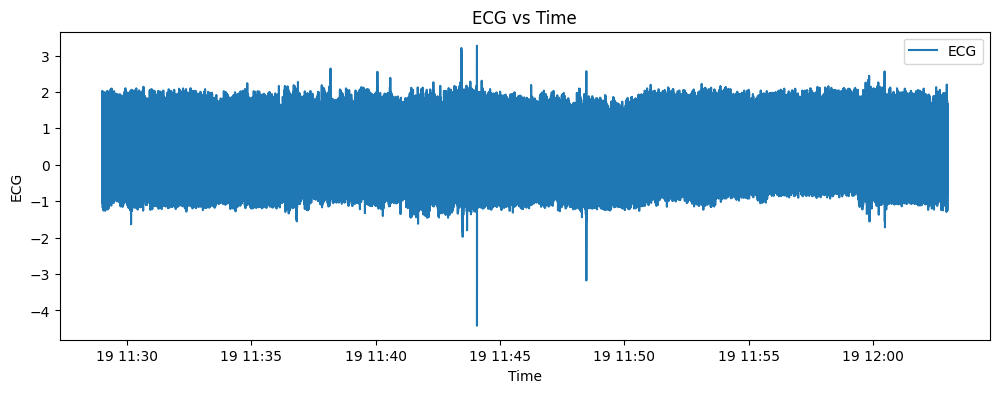

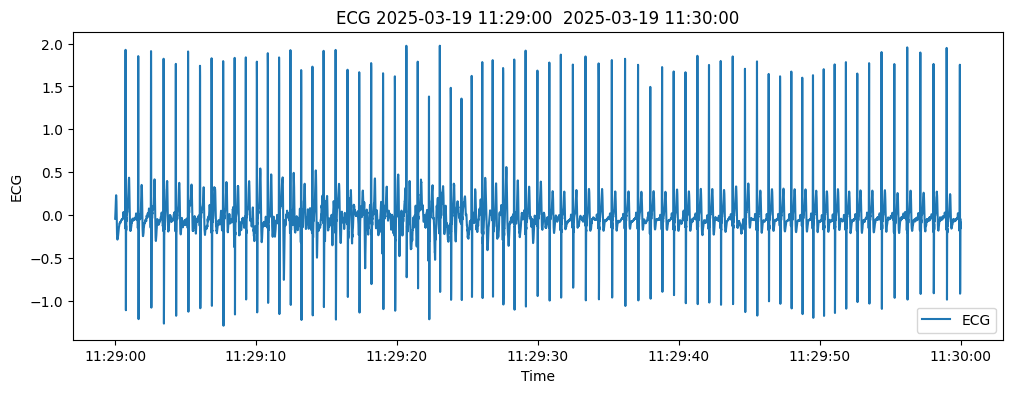

In [13]:
#quick plot
df=df_boutique1

plt.figure(figsize=(12, 4))
plt.plot(df['real_time'], df['ecg'], label='ECG')
plt.xlabel('Time')
plt.ylabel('ECG')
plt.title('ECG vs Time')
plt.legend()
plt.show()

start_time = pd.to_datetime('2025-03-19 11:29:00')
end_time = start_time + pd.Timedelta(minutes=1)


ecg_window = df[(df['real_time'] >= start_time) & (df['real_time'] < end_time)]


plt.figure(figsize=(12, 4))
plt.plot(ecg_window['real_time'], ecg_window['ecg_filtered'], label='ECG')
plt.xlabel('Time')
plt.ylabel('ECG')
plt.title(f'ECG {start_time}  {end_time}')
plt.legend()
plt.show()


In [8]:
#filtered
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    y = filtfilt(b, a, data)
    return y



In [9]:
fs=130

def hrv(ecg_segment, fs):
    try:
        wd, m = hp.process(ecg_segment, sample_rate=fs)
        return m
    except Exception as e:
        print("Error", e)
        return None

df['ecg_filtered'] = bandpass_filter(df['ecg'].values, 0.5, 40, fs)


window_size_1min = int(60 * fs)
hrv_temporal = []

for start_idx in range(0, len(df) - window_size_1min + 1, window_size_1min):
    end_idx = start_idx + window_size_1min
    ecg_segment = df['ecg_filtered'].iloc[start_idx:end_idx].values
    
    metrics = hrv(ecg_segment, fs)
    if metrics:
        metrics['start_idx'] = start_idx
        metrics['end_idx'] = end_idx
        hrv_temporal.append(metrics)

df_temporal = pd.DataFrame(hrv_temporal)


In [ ]:

fs = 130
window_size_5min = int(5 * 60 * fs)  #
results_freq = []

signal = df['ecg_filtered'].values

for start_idx in range(0, len(signal) - window_size_5min + 1, window_size_5min):
    end_idx = start_idx + window_size_5min
    segment = signal[start_idx:end_idx]
    
    try:
        wd, m = hp.process(segment, sample_rate=fs, calc_freq=True)
        freq_metrics = {
            'start_idx': start_idx,
            'end_idx': end_idx,
            'lf': m.get('lf', np.nan),
            'hf': m.get('hf', np.nan),
            'lf/hf': m.get('lf/hf', np.nan),
        }
        
        
        results_freq.append(freq_metrics)
        
    except Exception as e:
        print(f"[FREQ] Error en ventana {start_idx}-{end_idx}: {e}")
        results_freq.append({'start_idx': start_idx, 'end_idx': end_idx})

df_freq = pd.DataFrame(results_freq)


/opt/anaconda3/envs/richemont/lib/python3.10/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)


In [101]:
df_temporal 


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,start_idx,end_idx
0,77.682209,772.377622,45.488153,12.219674,19.845167,0.377049,0.016393,38.461538,13.918869,63.733140,2786.885476,0.218393,0.100000,0,7800
1,81.691234,734.472934,56.875973,17.339447,24.431404,0.362500,0.025000,46.153846,17.272266,79.012225,4287.394899,0.218602,0.133333,7800,15600
2,75.529966,794.386694,75.350848,27.960888,37.630646,0.452055,0.123288,42.307692,26.606277,103.625160,8661.621191,0.256755,0.133333,15600,23400
3,72.886717,823.195266,57.334072,20.537516,31.908105,0.507937,0.111111,38.461538,22.551863,77.626683,5499.754743,0.290517,0.133333,23400,31200
4,68.261999,878.966346,47.012096,22.224719,35.974159,0.548387,0.177419,42.307692,25.427888,61.804536,4937.197536,0.411424,0.100000,31200,39000
5,68.292026,878.579882,42.056647,23.415225,38.277950,0.587302,0.238095,38.461538,27.061640,52.987233,4504.797057,0.510720,0.133333,39000,46800
6,72.153449,831.561086,37.802952,21.097825,34.113166,0.515152,0.136364,30.769231,24.085583,47.122006,3565.585097,0.511132,0.200000,46800,54600
7,71.968811,833.694475,55.385311,20.418280,29.678469,0.400000,0.085714,38.461538,20.971456,75.545594,4977.228660,0.277600,0.100000,54600,62400
8,72.475088,827.870680,41.250113,19.127591,30.596530,0.492537,0.104478,38.461538,21.625264,53.516749,3635.808536,0.404084,0.100000,62400,70200
9,73.620830,814.986737,90.571903,24.865639,41.045290,0.641509,0.226415,69.230769,28.584426,115.138348,10339.495293,0.248262,0.100000,70200,78000


In [102]:

freq_intervals = pd.IntervalIndex.from_arrays(df_freq['start_idx'], df_freq['end_idx'], closed='left')


def get_freq_row(idx):

    pos = freq_intervals.get_indexer([idx])[0]
    if pos != -1:
        return df_freq.iloc[pos][['lf','hf','lf/hf']]
    else:
        return pd.Series([None, None, None], index=['lf','hf','lf/hf'])

df_temporal[['lf','hf','lf/hf']] = df_temporal['start_idx'].apply(get_freq_row)



In [103]:
df_all=df_temporal

In [104]:
df_all


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,start_idx,end_idx,lf,hf,lf/hf
0,77.682209,772.377622,45.488153,12.219674,19.845167,0.377049,0.016393,38.461538,13.918869,63.733140,2786.885476,0.218393,0.100000,0,7800,1427.304417,186.823148,7.639869
1,81.691234,734.472934,56.875973,17.339447,24.431404,0.362500,0.025000,46.153846,17.272266,79.012225,4287.394899,0.218602,0.133333,7800,15600,1427.304417,186.823148,7.639869
2,75.529966,794.386694,75.350848,27.960888,37.630646,0.452055,0.123288,42.307692,26.606277,103.625160,8661.621191,0.256755,0.133333,15600,23400,1427.304417,186.823148,7.639869
3,72.886717,823.195266,57.334072,20.537516,31.908105,0.507937,0.111111,38.461538,22.551863,77.626683,5499.754743,0.290517,0.133333,23400,31200,1427.304417,186.823148,7.639869
4,68.261999,878.966346,47.012096,22.224719,35.974159,0.548387,0.177419,42.307692,25.427888,61.804536,4937.197536,0.411424,0.100000,31200,39000,1427.304417,186.823148,7.639869
5,68.292026,878.579882,42.056647,23.415225,38.277950,0.587302,0.238095,38.461538,27.061640,52.987233,4504.797057,0.510720,0.133333,39000,46800,1546.708111,320.386117,4.827638
6,72.153449,831.561086,37.802952,21.097825,34.113166,0.515152,0.136364,30.769231,24.085583,47.122006,3565.585097,0.511132,0.200000,46800,54600,1546.708111,320.386117,4.827638
7,71.968811,833.694475,55.385311,20.418280,29.678469,0.400000,0.085714,38.461538,20.971456,75.545594,4977.228660,0.277600,0.100000,54600,62400,1546.708111,320.386117,4.827638
8,72.475088,827.870680,41.250113,19.127591,30.596530,0.492537,0.104478,38.461538,21.625264,53.516749,3635.808536,0.404084,0.100000,62400,70200,1546.708111,320.386117,4.827638
9,73.620830,814.986737,90.571903,24.865639,41.045290,0.641509,0.226415,69.230769,28.584426,115.138348,10339.495293,0.248262,0.100000,70200,78000,1546.708111,320.386117,4.827638


In [106]:
df_boutique1=pd.read_csv("/Users/laura/Documents/RICHEMONT/250319/Clement/Boutiques/Boutique3/hrv-features.csv")


In [107]:
df_boutique1[['start_time_freq', 'lf', 'hf', 'lf/hf']] = df_boutique1[['start_time_freq', 'lf', 'hf', 'lf/hf']].fillna(method='ffill', limit=4)

/var/folders/1m/2gsg5r5x3_xb8rgnzdgz8_t00000gn/T/ipykernel_75128/2846055078.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_boutique1[['start_time_freq', 'lf', 'hf', 'lf/hf']] = df_boutique1[['start_time_freq', 'lf', 'hf', 'lf/hf']].fillna(method='ffill', limit=4)


In [108]:
df_boutique1

,Unnamed: 0,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,...,s,sd1/sd2,breathingrate,start_time_time,start_time_freq,lf,hf,lf/hf,start_time,real_time
0,0,70.824524,847.164179,94.991060,79.723644,116.081868,0.796875,0.500000,80.0,81.985851,...,26288.145412,0.803281,0.166667,8764.256000,8764.256,1479.831699,1551.055639,0.954080,8764.256000,2025-03-19 12:45:24.033210
1,1,68.036853,881.875000,92.582311,66.569489,100.098312,0.885246,0.475410,40.0,70.755891,...,21490.297949,0.731868,0.166667,8824.690000,8764.256,1479.831699,1551.055639,0.954080,8824.690000,2025-03-19 12:46:24.467210
2,2,68.758815,872.615385,80.885045,71.461625,97.583711,0.741935,0.387097,80.0,68.928170,...,19335.274074,0.771957,0.266667,8885.138000,8764.256,1479.831699,1551.055639,0.954080,8885.138000,2025-03-19 12:47:24.915210
3,3,70.898042,846.285714,65.075153,24.853277,44.656499,0.768116,0.159420,40.0,31.576913,...,8374.320642,0.374059,0.100000,8945.572000,8764.256,1479.831699,1551.055639,0.954080,8945.572000,2025-03-19 12:48:25.349210
4,4,70.312500,853.333333,63.031317,40.185556,58.811764,0.661765,0.323529,40.0,41.584117,...,10385.901846,0.523071,0.300000,9006.019000,8764.256,1479.831699,1551.055639,0.954080,9006.019000,2025-03-19 12:49:25.796210
5,5,75.113809,798.787879,167.400039,82.752955,106.816834,0.819672,0.360656,80.0,75.358500,...,50990.442594,0.349885,0.233333,9066.453000,9066.453,12157.223591,11032.672612,1.101929,9066.453000,2025-03-19 12:50:26.230210
6,6,103.448276,580.000000,131.529464,61.967734,94.994737,0.840000,0.440000,40.0,67.161894,...,28018.143758,0.505774,0.107759,9126.900000,9066.453,12157.223591,11032.672612,1.101929,9126.900000,2025-03-19 12:51:26.677210
7,7,60.178306,997.037037,44.788790,34.724055,55.425626,0.740000,0.280000,40.0,39.191836,...,6268.490603,0.769800,0.166667,9187.334000,9066.453,12157.223591,11032.672612,1.101929,9187.334000,2025-03-19 12:52:27.111210
8,8,62.893082,954.000000,62.321746,45.160567,59.422508,0.603448,0.189655,40.0,41.972756,...,10001.617612,0.553369,0.266667,9247.781000,9066.453,12157.223591,11032.672612,1.101929,9247.781000,2025-03-19 12:53:27.558210
9,9,99.324324,604.081633,151.022614,64.375460,89.005344,0.731707,0.365854,40.0,62.932501,...,36992.421947,0.336347,0.135135,9308.229000,9066.453,12157.223591,11032.672612,1.101929,9308.229000,2025-03-19 12:54:28.006210


In [109]:
df_all

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,start_idx,end_idx,lf,hf,lf/hf
0,77.682209,772.377622,45.488153,12.219674,19.845167,0.377049,0.016393,38.461538,13.918869,63.733140,2786.885476,0.218393,0.100000,0,7800,1427.304417,186.823148,7.639869
1,81.691234,734.472934,56.875973,17.339447,24.431404,0.362500,0.025000,46.153846,17.272266,79.012225,4287.394899,0.218602,0.133333,7800,15600,1427.304417,186.823148,7.639869
2,75.529966,794.386694,75.350848,27.960888,37.630646,0.452055,0.123288,42.307692,26.606277,103.625160,8661.621191,0.256755,0.133333,15600,23400,1427.304417,186.823148,7.639869
3,72.886717,823.195266,57.334072,20.537516,31.908105,0.507937,0.111111,38.461538,22.551863,77.626683,5499.754743,0.290517,0.133333,23400,31200,1427.304417,186.823148,7.639869
4,68.261999,878.966346,47.012096,22.224719,35.974159,0.548387,0.177419,42.307692,25.427888,61.804536,4937.197536,0.411424,0.100000,31200,39000,1427.304417,186.823148,7.639869
5,68.292026,878.579882,42.056647,23.415225,38.277950,0.587302,0.238095,38.461538,27.061640,52.987233,4504.797057,0.510720,0.133333,39000,46800,1546.708111,320.386117,4.827638
6,72.153449,831.561086,37.802952,21.097825,34.113166,0.515152,0.136364,30.769231,24.085583,47.122006,3565.585097,0.511132,0.200000,46800,54600,1546.708111,320.386117,4.827638
7,71.968811,833.694475,55.385311,20.418280,29.678469,0.400000,0.085714,38.461538,20.971456,75.545594,4977.228660,0.277600,0.100000,54600,62400,1546.708111,320.386117,4.827638
8,72.475088,827.870680,41.250113,19.127591,30.596530,0.492537,0.104478,38.461538,21.625264,53.516749,3635.808536,0.404084,0.100000,62400,70200,1546.708111,320.386117,4.827638
9,73.620830,814.986737,90.571903,24.865639,41.045290,0.641509,0.226415,69.230769,28.584426,115.138348,10339.495293,0.248262,0.100000,70200,78000,1546.708111,320.386117,4.827638


In [74]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
df=df_boutique1
df_all = df_all.drop(df_all.index[-1])

excluded_columns = ['start time', 'start_time_time', 'start_time_freq', 'real_time',]  # añade las que necesites

common_columns = list(set(df.columns).intersection(set(df_all.columns)))
common_columns = [col for col in common_columns if col not in excluded_columns]

numeric_columns = [
    col for col in common_columns
    if np.issubdtype(df[col].dtype, np.number) and np.issubdtype(df_all[col].dtype, np.number)
]

# 1. Estadísticas descriptivas
print("=== Estadísticas descriptivas: df ===")
print(df[numeric_columns].describe())


=== Estadísticas descriptivas: df ===
            rmssd  breathingrate      hr_mad            lf      pnn50  \
count   33.000000      33.000000   33.000000     33.000000  33.000000   
mean    89.159919       0.212664   55.757576   3538.226483   0.360435   
std     38.610039       0.094336   23.852450   4213.690395   0.126095   
min     48.205908       0.000000   40.000000   1078.742856   0.180328   
25%     59.581876       0.166667   40.000000   1500.504601   0.238806   
50%     76.107852       0.233333   40.000000   1850.583512   0.363636   
75%    109.655107       0.266667   80.000000   2090.353496   0.446154   
max    207.162084       0.400000  120.000000  13291.495260   0.645161   

                  s      lf/hf          ibi         bpm        sdsd  \
count     33.000000  33.000000    33.000000   33.000000   33.000000   
mean   18838.699299   1.537604   877.871263   69.120847   60.987581   
std    11008.604217   0.845924    87.284762    8.154067   25.311515   
min     4743.947357 

In [75]:

print("\n=== Estadísticas descriptivas: df_all ===")
print(df_all[numeric_columns].describe())



=== Estadísticas descriptivas: df_all ===
            rmssd  breathingrate      hr_mad           lf      pnn50  \
count   33.000000      33.000000   33.000000    30.000000  33.000000   
mean    42.489902       0.148359   45.454545  1678.118278   0.172743   
std     49.454358       0.077815   35.085675   490.664350   0.246663   
min     12.862308       0.000000   15.384615   929.695166   0.000000   
25%     22.426738       0.100000   30.769231  1374.822338   0.032258   
50%     27.713667       0.133333   38.461538  1720.877732   0.063830   
75%     40.216377       0.166667   42.307692  1792.360070   0.210526   
max    260.768096       0.422833  200.000000  2530.076630   1.000000   

                  s      lf/hf          ibi         bpm        sdsd  \
count     33.000000  30.000000    33.000000   33.000000   33.000000   
mean    8283.774010   5.111757   855.957016   75.155000   24.646038   
std    14976.627732   3.117127   172.362938   27.326638   23.543652   
min      464.732641   0.

In [76]:
from scipy.stats import ttest_rel


resultados = []

for col in numeric_columns:
    # t-test para muestras relacionadas (pareadas)
    stat, pvalue = ttest_rel(df[col], df_all[col])
    
    diff_mean = (df[col] - df_all[col]).mean()
    diff_std = (df[col] - df_all[col]).std()

    resultados.append({
        'columna': col,
        'media_diferencia': diff_mean,
        'std_diferencia': diff_std,
        't-statistic': stat,
        'p-value': pvalue
    })

resultados_df = pd.DataFrame(resultados)
print(resultados_df)


          columna  media_diferencia  std_diferencia  t-statistic       p-value
0           rmssd         46.670017       59.987458     4.469248  9.222560e-05
1   breathingrate          0.064305        0.120429     3.067389  4.370221e-03
2          hr_mad         10.303030       42.042851     1.407764  1.688418e-01
3              lf       1916.906603     4424.675309          NaN           NaN
4           pnn50          0.187693        0.257539     4.186601  2.067528e-04
5               s      10554.925290    18374.138552     3.299933  2.379719e-03
6           lf/hf         -3.739691        2.804282          NaN           NaN
7             ibi         21.914247      218.422829     0.576349  5.684115e-01
8             bpm         -6.034152       30.359409    -1.141773  2.620203e-01
9            sdsd         36.341543       33.096991     6.307712  4.466957e-07
10           sdnn         19.074866       43.678357     2.508720  1.737748e-02
11            sd2         19.370302       31.474239 

In [77]:
significativos = resultados_df[resultados_df['p-value'] < 0.05]
print(significativos)

          columna  media_diferencia  std_diferencia  t-statistic       p-value
0           rmssd         46.670017       59.987458     4.469248  9.222560e-05
1   breathingrate          0.064305        0.120429     3.067389  4.370221e-03
4           pnn50          0.187693        0.257539     4.186601  2.067528e-04
5               s      10554.925290    18374.138552     3.299933  2.379719e-03
9            sdsd         36.341543       33.096991     6.307712  4.466957e-07
10           sdnn         19.074866       43.678357     2.508720  1.737748e-02
11            sd2         19.370302       31.474239     3.535396  1.265371e-03
12          pnn20          0.269177        0.204805     7.550154  1.341511e-08
14            sd1         33.649284       41.795775     4.624879  5.891919e-05


In [105]:
df_all.to_csv('/Users/laura/Documents/RICHEMONT/250319/Clement/Boutiques/Boutique3/POLAR.csv', index=False)

In [79]:
df_boutique1

,Unnamed: 0,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,...,s,sd1/sd2,breathingrate,start_time_time,start_time_freq,lf,hf,lf/hf,start_time,real_time
0,0,69.885213,858.550725,85.487102,79.835471,122.522507,0.823529,0.588235,80.0,86.636496,...,23278.463933,1.012972,0.000000,4230.897000,4230.897000,1078.742856,785.919917,1.372586,4230.897000,2025-03-19 11:29:50.674210
1,1,70.490670,851.176471,74.784581,77.499963,109.655107,0.833333,0.409091,40.0,77.537870,...,15636.426591,1.207925,0.000000,4291.330333,4230.897000,1078.742856,785.919917,1.372586,4291.330333,2025-03-19 11:30:51.107543
2,2,67.027759,895.151515,60.609091,47.532238,67.116432,0.753846,0.215385,40.0,47.456489,...,10680.948732,0.662417,0.233333,4351.778000,4230.897000,1078.742856,785.919917,1.372586,4351.778000,2025-03-19 11:31:51.555210
3,3,68.228106,879.402985,53.751240,36.267550,50.930731,0.621212,0.196970,40.0,35.949664,...,7365.240150,0.551255,0.200000,4412.212000,4230.897000,1078.742856,785.919917,1.372586,4412.212000,2025-03-19 11:32:51.989210
4,4,69.152542,867.647059,72.031808,52.780982,78.796924,0.761194,0.373134,40.0,55.660237,...,14622.768694,0.665595,0.266667,4472.659000,4230.897000,1078.742856,785.919917,1.372586,4472.659000,2025-03-19 11:33:52.436210
5,5,67.715458,886.060606,70.750924,58.616870,86.602540,0.796875,0.375000,40.0,61.179807,...,14341.889361,0.819898,0.333333,4533.093000,4533.093000,1850.583512,1620.461479,1.142010,4533.093000,2025-03-19 11:34:52.870210
6,6,68.322981,878.181818,65.108513,34.255474,59.581876,0.796875,0.359375,40.0,42.130749,...,10315.594583,0.540573,0.266667,4593.540000,4533.093000,1850.583512,1620.461479,1.142010,4593.540000,2025-03-19 11:35:53.317210
7,7,67.229978,892.459016,94.585476,95.680807,127.925417,0.754386,0.456140,80.0,90.422898,...,25618.442155,1.002661,0.233333,4653.988000,4533.093000,1850.583512,1620.461479,1.142010,4653.988000,2025-03-19 11:36:53.765210
8,8,70.113314,855.757576,92.081331,81.724916,117.972286,0.809524,0.476190,60.0,83.414171,...,22770.786997,0.959956,0.233333,4714.435000,4533.093000,1850.583512,1620.461479,1.142010,4714.435000,2025-03-19 11:37:54.212210
9,9,69.119670,868.059701,85.766758,78.913330,118.659176,0.830769,0.523077,80.0,83.832462,...,22514.633319,0.980640,0.333333,4774.869000,4533.093000,1850.583512,1620.461479,1.142010,4774.869000,2025-03-19 11:38:54.646210


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


stats_boutique1 = df_boutique1.describe().loc[['mean', 'std']].T.reset_index()
stats_boutique1.columns = ['metric', 'mean_boutique1', 'std_boutique1']

stats_all = df_all.describe().loc[['mean', 'std']].T.reset_index()
stats_all.columns = ['metric', 'mean_all', 'std_all']


stats = pd.merge(stats_boutique1, stats_all, on='metric')


metrics = df_boutique1.select_dtypes(include='number').columns

for metric in metrics:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=[df_boutique1[metric], df_all[metric]], palette='pastel')
    plt.xticks([0,1], ['Boutique1', 'All'])
    plt.title(f'Boxplot de {metric}')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

KeyError: 'Unnamed: 0'

<Figure size 600x400 with 0 Axes>